In [1]:
import gribscan
from pathlib import Path
import json
import xarray as xr
import rich

# Using `gribscan` from command line

https://gribscan.readthedocs.io/en/latest/getting_started.html#command-line-usage

Starting up:
```bash
(base) [nhae@ac6-102 ~]$ cd /ec/res4/hpcperm/hlam/ml_data
(base) [nhae@ac6-102 ml_data]$ cd uwcw-dini-lcd/
(base) [nhae@ac6-102 uwcw-dini-lcd]$ source ~/git-repos/gribscan-demo/.venv/bin/activate
(gribscan-demo) (base) [nhae@ac6-102 uwcw-dini-lcd]$ ls -l
total 1075612
-rwxrwxr-x 1 nhae accord 492433729 Feb 27 21:38 fc2025022705+000CONTROL__dmi_sf
-rwxrwxr-x 1 nhae accord 608683739 Feb 27 21:44 fc2025022705+001CONTROL__dmi_sf
```

Building index files (on for each grib file):
```bash
(gribscan-demo) (base) [nhae@ac6-102 uwcw-dini-lcd]$ gribscan-index *_sf -n 4
(gribscan-demo) (base) [nhae@ac6-102 uwcw-dini-lcd]$ ls -l
total 1075465
-rwxrwxr-x 1 nhae accord 492433729 Feb 27 21:38 fc2025022705+000CONTROL__dmi_sf
-rw-r----- 1 nhae dk        140763 Feb 28 06:38 fc2025022705+000CONTROL__dmi_sf.index
-rwxrwxr-x 1 nhae accord 608683739 Feb 27 21:44 fc2025022705+001CONTROL__dmi_sf
-rw-r----- 1 nhae dk        143973 Feb 28 06:38 fc2025022705+001CONTROL__dmi_sf.index
```

Building reference files:
```bash
(gribscan-demo) (base) [nhae@ac6-102 uwcw-dini-lcd]$ gribscan-build *.index -o refs/ --prefix `pwd`/
(gribscan-demo) (base) [nhae@ac6-102 uwcw-dini-lcd]$ tree
.
|-- fc2025022705+000CONTROL__dmi_sf
|-- fc2025022705+000CONTROL__dmi_sf.index
|-- fc2025022705+001CONTROL__dmi_sf
|-- fc2025022705+001CONTROL__dmi_sf.index
`-- refs
    `-- atm2d.json
```
`

In [2]:
ds = xr.open_zarr(f"reference::/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/refs/atm2d.json")
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 2, cell: 3061036, level: 9)
Coordinates:
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
  * time     (time) datetime64[ns] 16B 2025-02-27T05:00:00 2025-02-27T06:00:00
Dimensions without coordinates: cell
Data variables: (12/43)
    100u     (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    100v     (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    10efg    (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    10fg     (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    10nfg    (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    10si     (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    ...       ...
    ttr      (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    u        (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    unknown  (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    v        (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    vis      (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
    z        (time, cell) float64 49MB dask.array<chunksize=(1, 3061036), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ekmi
    centreDescription:  Copenhagen
    subCentre:          255
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ma...

In [3]:
ds.u

<xarray.DataArray 'u' (time: 2, cell: 3061036)> Size: 49MB
dask.array<open_dataset-u, shape=(2, 3061036), dtype=float64, chunksize=(1, 3061036), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 16B 2025-02-27T05:00:00 2025-02-27T06:00:00
Dimensions without coordinates: cell
Attributes: (12/17)
    paramId:                    131
    dataType:                   cf
    numberOfPoints:             3061036
    typeOfLevel:                heightAboveSea
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     eastward_wind
    cfVarName:                  u
    missingValue:               3.4028234663852886e+38
    totalNumber:                31
    NV:                         182
    gridDefinitionDescription:  Lambert conformal

In [4]:
ds.u.isel(time=0).values

array([-1.22388077e+00, -1.24380875e+00, -1.22532654e+00, ...,
        9.99900000e+03,  9.99900000e+03,  9.99900000e+03])

Data is now accessible via `xr.Dataset`, but the spatial coordinates are all collapsed into the `cell` coordinate...

This is why I implemented the [`HarmonieMagician` class](https://github.com/leifdenby/gribscan/blob/harmonie-rotated-and-lambert-grids/gribscan/magician.py#L142), which understands Harmonie projections, can compute the lat/lon coordinates and splits the `cell` coordinate into `x` and `y` coordinates. Currently in PR: https://github.com/gribscan/gribscan/pull/22, and on my branch https://github.com/leifdenby/gribscan/tree/harmonie-rotated-and-lambert-grids


```bash
Using Harmonie "magician" which splits variables out by level-type and adds Harmonie spatial coordinates (currently support lambert and rotated lat/lon projections):
```bash
1 directory, 5 files
(gribscan-demo) (base) [nhae@ac6-102 uwcw-dini-lcd]$ gribscan-build *.index -o refs/ --prefix `pwd`/ --magician harmonie
(gribscan-demo) (base) [nhae@ac6-102 uwcw-dini-lcd]$ tree
.
|-- fc2025022705+000CONTROL__dmi_sf
|-- fc2025022705+000CONTROL__dmi_sf.index
|-- fc2025022705+001CONTROL__dmi_sf
|-- fc2025022705+001CONTROL__dmi_sf.index
`-- refs
    |-- adiabaticCondensation.json
    |-- atm2d.json
    |-- cloudTop.json
    |-- entireAtmosphere.json
    |-- freeConvection.json
    |-- heightAboveGround.json
    |-- heightAboveSea.json
    |-- hybrid.json
    |-- isothermal.json
    |-- isothermZero.json
    |-- neutralBuoyancy.json
    |-- nominalTop.json
    `-- surface.json

1 directory, 17 files
```

In [5]:
ds = xr.open_zarr(f"reference::/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/refs/heightAboveGround.json")
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 2, y: 1606, x: 1906, level: 9)
Coordinates:
    lat      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
    lon      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * time     (time) datetime64[ns] 16B 2025-02-27T05:00:00 2025-02-27T06:00:00
  * x        (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.28e+06 2.282e+06
  * y        (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.619e+06 1.621e+06
Data variables: (12/31)
    100u     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    100v     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10efg    (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10fg     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10nfg    (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10si     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    ...       ...
    t        (time, level, y, x) float64 441MB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    u        (time, level, y, x) float64 441MB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    unknown  (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    v        (time, level, y, x) float64 441MB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    vis      (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    z        (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ekmi
    centreDescription:  Copenhagen
    subCentre:          255
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ha...

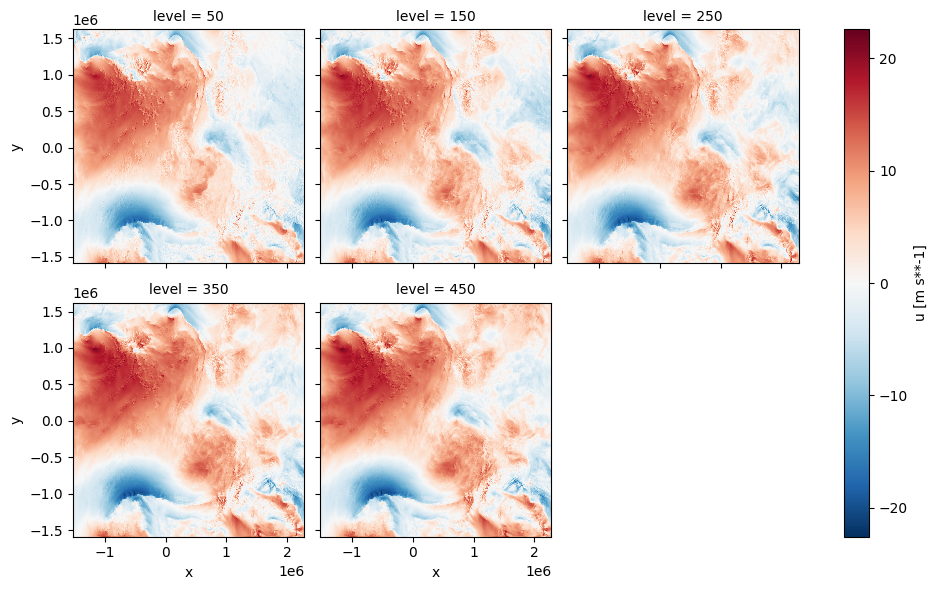

In [6]:
ds.u.isel(time=0).dropna(dim="level").plot(col="level", col_wrap=3)

# Using gribscan from python

In [7]:
fp_root = Path("/ec/res4/hpcperm/hlam/ml_data")

In [8]:
!ls {fp_root}

Aemet_examples	ie  README.md  uwcw  uwcw-dini-lcd


In [9]:
fp_examples_root = fp_root / "uwcw-dini-lcd"

In [10]:
!tree {fp_examples_root}

/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd
├── fc2025022705+000CONTROL__dmi_sf
├── fc2025022705+000CONTROL__dmi_sf.index
├── fc2025022705+001CONTROL__dmi_sf
├── fc2025022705+001CONTROL__dmi_sf.index
└── refs
    ├── adiabaticCondensation.json
    ├── atm2d.json
    ├── cloudTop.json
    ├── entireAtmosphere.json
    ├── freeConvection.json
    ├── heightAboveGround.json
    ├── heightAboveSea.json
    ├── hybrid.json
    ├── isothermal.json
    ├── isothermZero.json
    ├── neutralBuoyancy.json
    ├── nominalTop.json
    └── surface.json

1 directory, 17 files


In [11]:
fps = list(fp_examples_root.rglob("*sf"))
len(fps), fps[-1]

(2,
 PosixPath('/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+000CONTROL__dmi_sf'))

In [12]:
fp_gribfile = fps[-1]
fprel = fp_gribfile.relative_to(fp_root)
fprel

PosixPath('uwcw-dini-lcd/fc2025022705+000CONTROL__dmi_sf')

In [13]:
fp_index = Path("indexes") / f"{fprel}.index"
fp_index

PosixPath('indexes/uwcw-dini-lcd/fc2025022705+000CONTROL__dmi_sf.index')

In [14]:
fps_index = []
for fp_gribfile in fps:
    fprel = fp_gribfile.relative_to(fp_root)
    fp_index = Path("indexes") / f"{fprel}.index"
    fp_index.parent.mkdir(exist_ok=True, parents=True)
    gribscan.write_index(gribfile=fp_gribfile, idxfile=fp_index)
    fps_index.append(fp_index)
    

magician = gribscan.magician.HarmonieMagician()  # use magician fitting the grib file
refs = gribscan.grib_magic(
    filenames=fps_index,
    magician=magician,
    global_prefix=f"{fp_examples_root}/"
)

refs.keys()

dict_keys(['heightAboveGround', 'hybrid', 'heightAboveSea', 'surface', 'entireAtmosphere', 'isothermZero', 'isothermal', 'nominalTop', 'adiabaticCondensation', 'freeConvection', 'neutralBuoyancy', 'cloudTop'])

In [15]:
# print the first 10 items in the refs["heightAboveGround"] dictionary
list(refs["heightAboveGround"].items())[:10]

[('hcc/1.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   0,
   6122991]),
 ('lcc/1.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   6122991,
   6122991]),
 ('mcc/1.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   12245982,
   6122991]),
 ('cc/1.0.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   18368973,
   6122991]),
 ('cc/1.1.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   24491964,
   9184027]),
 ('t/1.0.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   33675991,
   6122991]),
 ('2t/1.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   39798982,
   6122991]),
 ('t/1.2.0.0',
  ['/ec/res4/hpcperm/hlam/ml_data/uwcw-dini-lcd/fc2025022705+001CONTROL__dmi_sf',
   45921973,
   6122991]),
 ('t/1.3.0.0',


In [16]:
level_type = "heightAboveGround"
fp_ref = Path("refs") / f"{fprel}.{level_type}.json"
fp_ref

PosixPath('refs/uwcw-dini-lcd/fc2025022705+000CONTROL__dmi_sf.heightAboveGround.json')

In [17]:
fp_ref.parent.mkdir(exist_ok=True, parents=True)
with open(fp_ref, "w") as outfile:
    json.dump(refs[level_type], outfile)

In [18]:
ds = xr.open_zarr(f"reference::{fp_ref}")
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 2, y: 1606, x: 1906, level: 9)
Coordinates:
    lat      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
    lon      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * time     (time) datetime64[ns] 16B 2025-02-27T05:00:00 2025-02-27T06:00:00
  * x        (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.28e+06 2.282e+06
  * y        (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.619e+06 1.621e+06
Data variables: (12/31)
    100u     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    100v     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10efg    (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10fg     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10nfg    (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    10si     (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    ...       ...
    t        (time, level, y, x) float64 441MB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    u        (time, level, y, x) float64 441MB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    unknown  (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    v        (time, level, y, x) float64 441MB dask.array<chunksize=(1, 1, 1606, 1906), meta=np.ndarray>
    vis      (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    z        (time, y, x) float64 49MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ekmi
    centreDescription:  Copenhagen
    subCentre:          255
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ha...

In [19]:
ds.u

<xarray.DataArray 'u' (time: 2, level: 9, y: 1606, x: 1906)> Size: 441MB
dask.array<open_dataset-u, shape=(2, 9, 1606, 1906), dtype=float64, chunksize=(1, 1, 1606, 1906), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
    lon      (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * time     (time) datetime64[ns] 16B 2025-02-27T05:00:00 2025-02-27T06:00:00
  * x        (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.28e+06 2.282e+06
  * y        (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.619e+06 1.621e+06
Attributes: (12/17)
    paramId:                    131
    dataType:                   cf
    numberOfPoints:             3061036
    typeOfLevel:                heightAboveGround
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     eastward_wind
    cfVarName:                  u
    missingValue:               3.4028234663852886e+38
    totalNumber:                31
    NV:                         182
    gridDefinitionDescription:  Lambert conformal

In [20]:
da_u_slice = ds.u.isel(y=0, x=slice(0, 100))
da_u_slice

<xarray.DataArray 'u' (time: 2, level: 9, x: 100)> Size: 14kB
dask.array<getitem, shape=(2, 9, 100), dtype=float64, chunksize=(1, 1, 100), chunktype=numpy.ndarray>
Coordinates:
    lat      (x) float64 800B dask.array<chunksize=(100,), meta=np.ndarray>
  * level    (level) int64 72B 0 2 50 100 150 250 300 350 450
    lon      (x) float64 800B dask.array<chunksize=(100,), meta=np.ndarray>
  * time     (time) datetime64[ns] 16B 2025-02-27T05:00:00 2025-02-27T06:00:00
  * x        (x) float64 800B -1.528e+06 -1.526e+06 ... -1.332e+06 -1.33e+06
    y        float64 8B -1.589e+06
Attributes: (12/17)
    paramId:                    131
    dataType:                   cf
    numberOfPoints:             3061036
    typeOfLevel:                heightAboveGround
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     eastward_wind
    cfVarName:                  u
    missingValue:               3.4028234663852886e+38
    totalNumber:                31
    NV:                         182
    gridDefinitionDescription:  Lambert conformal

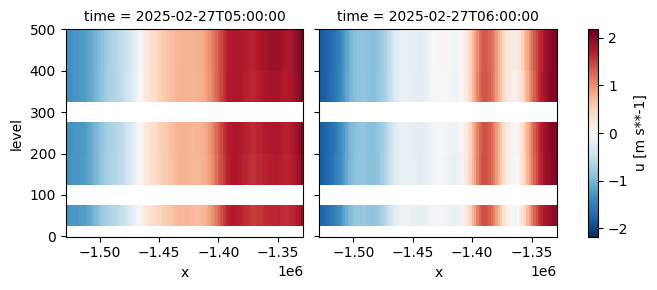

In [21]:
da_u_slice.plot(col="time", y="level")

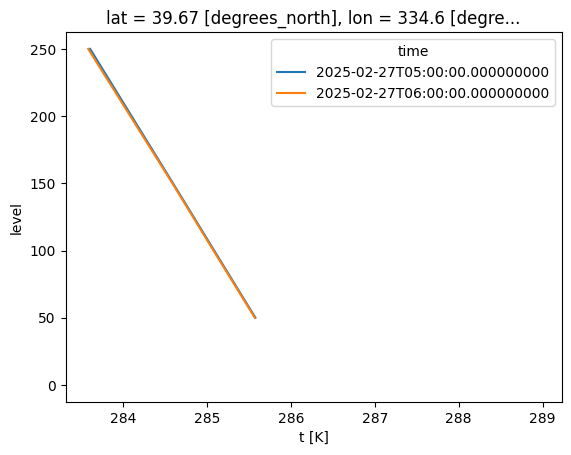

In [24]:
da_t_point = ds.t.isel(y=0, x=0)
da_t_point.plot(hue="time", y="level")